In [32]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt
import wandb

### Get the stock_prediction dataframe

In [2]:
stock_prediction_df = pd.read_csv('Code/baseline-implementation/stock_prediction.csv')
stock_prediction_df.drop(columns=['Unnamed: 0'],inplace=True)
stock_prediction_df.head()

,Date,sentiment,PriceDiff
0,2016-01-05,0.400000,-0.459333
1,2016-01-06,0.200000,-0.971214
2,2016-01-07,0.111111,0.116552
3,2016-01-08,0.400000,0.358770
4,2016-01-11,0.400000,0.326792


### Feature Engineering

In [3]:
# Create lagged features for the price_diff values
for i in range(1, 8):
    stock_prediction_df[f'PriceDiff_{i}'] = stock_prediction_df['PriceDiff'].shift(i)

# Remove missing values
stock_prediction_df.dropna(inplace=True)
stock_prediction_df.head()

,Date,sentiment,PriceDiff,PriceDiff_1,PriceDiff_2,PriceDiff_3,PriceDiff_4,PriceDiff_5,PriceDiff_6,PriceDiff_7
7,2016-01-14,0.20,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214,-0.459333
8,2016-01-15,0.75,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214
9,2016-01-19,0.50,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552
10,2016-01-20,0.80,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770
11,2016-01-21,0.20,1.170031,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792


### Split data into train and test

In [4]:
stock_X = stock_prediction_df[['sentiment', 'PriceDiff_1', 'PriceDiff_2', 'PriceDiff_3', 'PriceDiff_4', 'PriceDiff_5', 'PriceDiff_6', 'PriceDiff_7']]
stock_Y = stock_prediction_df.PriceDiff
X_train = stock_X.loc[:"2016-08-31"]
y_train = stock_Y.loc[:"2016-08-31"]
X_test = stock_X.loc["2016-09-01":]
y_test = stock_Y.loc["2016-09-01":]

### LSTM model

In [51]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8, 50)             10400     
                                                                 
 dropout_6 (Dropout)         (None, 8, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 8, 50)             20200     
                                                                 
 dropout_7 (Dropout)         (None, 8, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

#### Compile the model

In [52]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#### Train the model

In [62]:
model.fit(X_train, y_train, epochs=1000, batch_size=32)

Epoch 1/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 2/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 4/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 6/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.0190
Epoch 7/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0166
Epoch 8/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 9/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0222
Epoch 10/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0267
Epoch 11/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0619
Epoch 12/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0520
Epoch 13/1000
7/7 [=============================

#### Get predictions for train and test dataset

In [63]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
predicted_price_diff = np.concatenate((predictions_train,predictions_test),axis=0)

2/2 [==============================] - 0s 3ms/step


### Add predictions to dataset

In [64]:
stock_prediction_df['Predicted Price Diff'] = predicted_price_diff
stock_prediction_df.head()

,Date,sentiment,PriceDiff,PriceDiff_1,PriceDiff_2,PriceDiff_3,PriceDiff_4,PriceDiff_5,PriceDiff_6,PriceDiff_7,Predicted Price Diff
7,2016-01-14,0.20,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214,-0.459333,-0.517043
8,2016-01-15,0.75,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,-0.971214,-0.111107
9,2016-01-19,0.50,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,0.116552,0.036377
10,2016-01-20,0.80,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,0.358770,-0.125046
11,2016-01-21,0.20,1.170031,-0.111979,0.029711,-0.107401,-0.546173,0.486757,-0.587307,0.326792,1.378826


<AxesSubplot: >

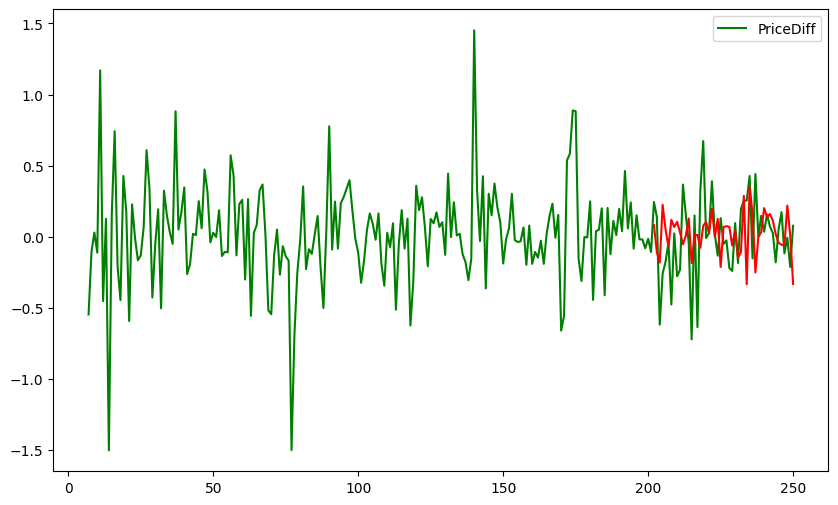

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
stock_prediction_df.plot(y='PriceDiff',color='green',ax=ax)
stock_prediction_df.loc['2016-08-01':, 'Predicted Price Diff'].plot(ax=ax, color='red', label='Predicted Price Diff')
# stock_prediction_df.plot(y='Predicted Price Diff',color='red',ax=ax)